In [3]:
import wave,os,librosa,tqdm,time,warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa, os, cv2, pickle, tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from cuml.svm import SVC as cuSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE
import IPython.display as ipd

In [2]:
dpath = '/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL'
audio_path = os.path.join(dpath,os.listdir(dpath)[0])
y, sr = librosa.load(audio_path,sr=16000)
print(y.shape)
print(sr)

(64773,)
16000


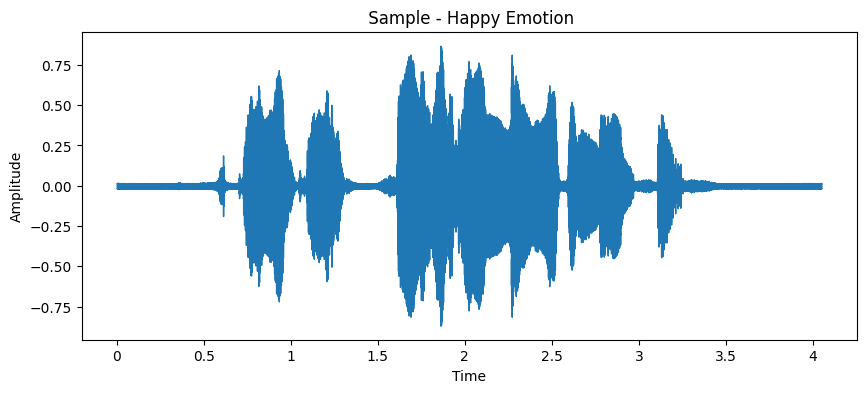

In [3]:
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(" Sample - Happy Emotion")
plt.ylabel("Amplitude")
plt.show()

In [4]:
pip install noisereduce

Note: you may need to restart the kernel to use updated packages.


KL_su14.wav
JE_sa01.wav
JK_f14.wav


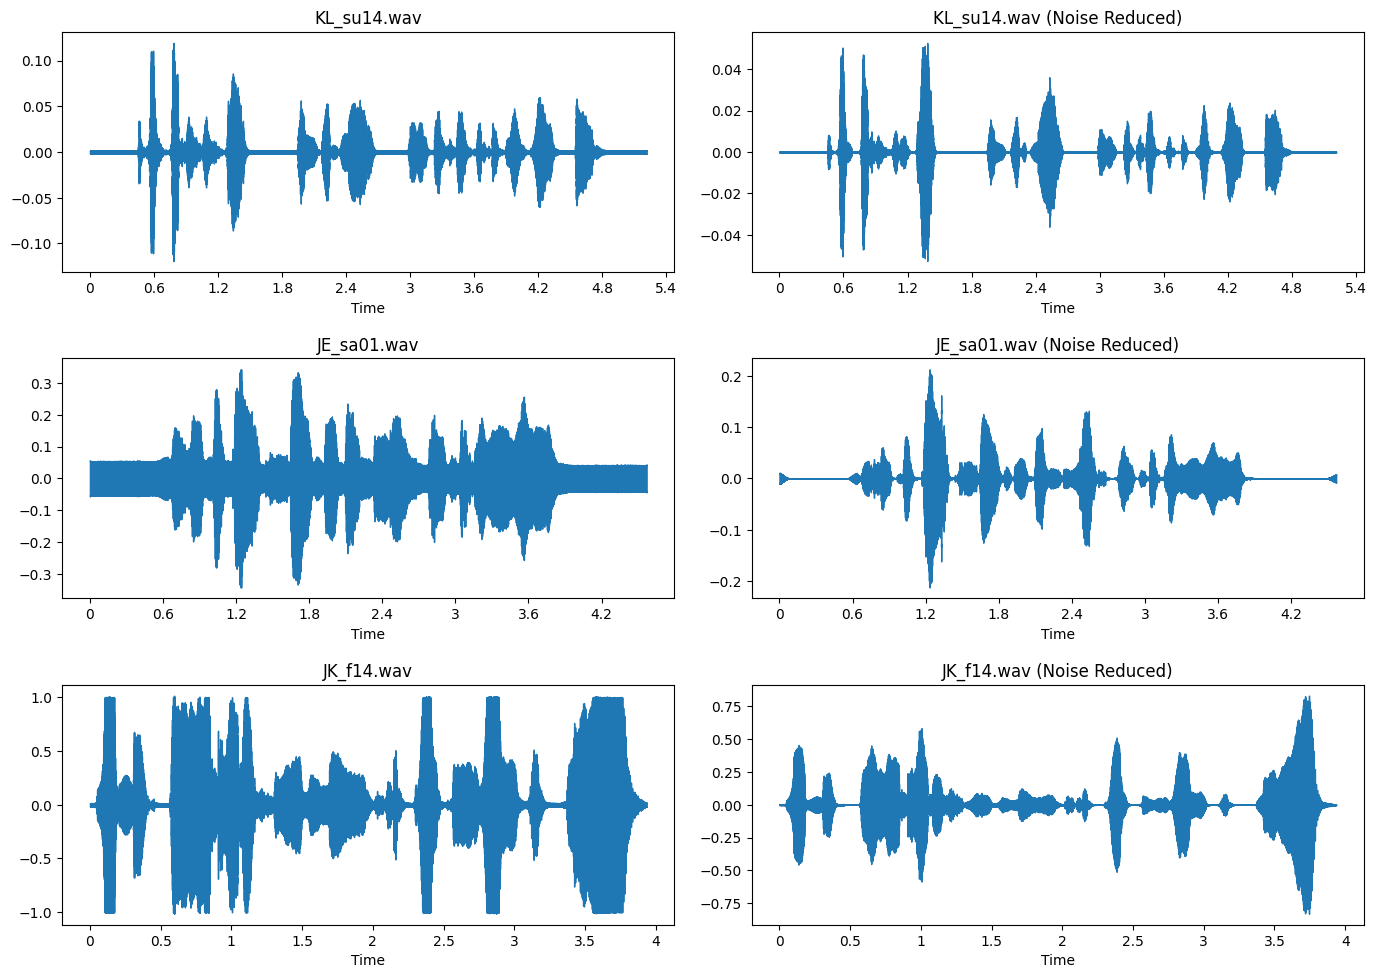

In [43]:
import noisereduce as nr
import re
labdict = { 'a': 'anger', 'd': 'disgust', 'f': 'fear', 'h': 'happiness', 'sa': 'sadness', 'su': 'surprise', 'n': 'Neutral'}
wavlabs = dict()
plt.figure(figsize=(14, 10))
rwav = np.random.choice(os.listdir(dpath),500)
wavs = []
i = 0
for p in rwav:
    path = os.path.join(dpath,p)
    print(p)
    label = labdict[re.match(r'^[a-zA-Z]+',p.split('_')[1]).group()]
    i+=1
    y,sr = librosa.load(path,sr=16000)
    wavs.append(p)
    ytrim,index = librosa.effects.trim(y,top_db=30)
    yclean = nr.reduce_noise(ytrim,sr)
    plt.subplot(3,2,i)
    plt.title(p)
    librosa.display.waveshow(ytrim, sr=sr)
    i+=1
    plt.subplot(3,2,i)
    plt.title(p+' (Noise Reduced)')
    librosa.display.waveshow(yclean, sr=sr)
    if i==6:
        break
plt.tight_layout(pad=1.5)
plt.show()

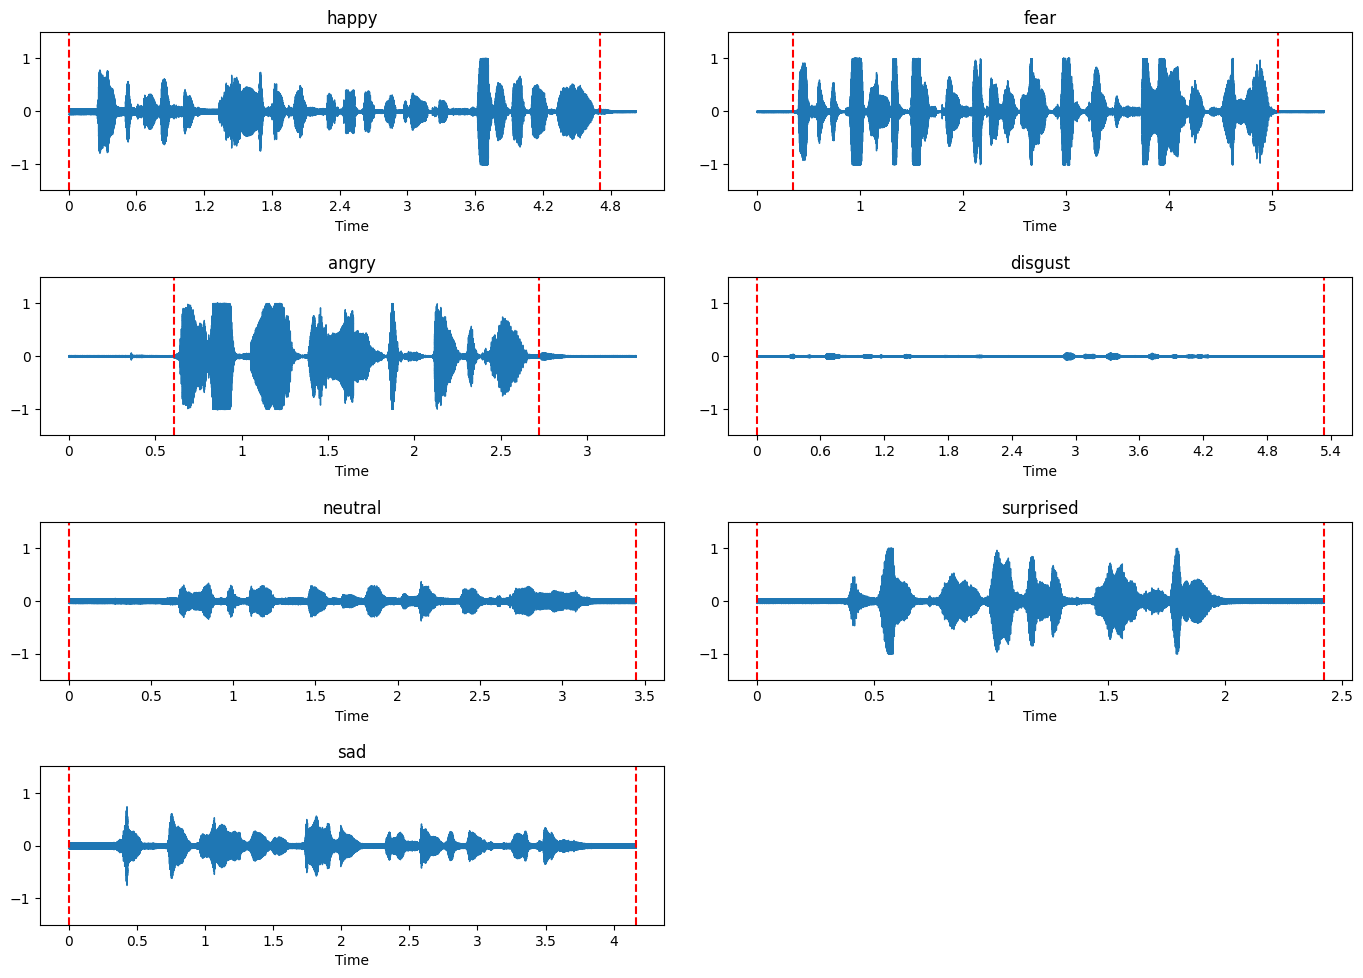

In [44]:
import noisereduce as nr
labdict = { 'a': 'angry', 'd': 'disgust', 'f': 'fear', 'h': 'happy', 'sa': 'sad', 'su': 'surprised', 'n': 'neutral'}
plt.figure(figsize=(14, 10))
emos,i = [],1
rwav = np.random.choice(os.listdir(dpath),500)
for wav in rwav:
  lab = labdict[re.match(r'^[a-zA-Z]+',wav.split('_')[1]).group()]
  if lab not in emos:
    emos.append(lab)
    audio_path = os.path.join(dpath,wav)
    y, sr = librosa.load(audio_path,sr=16000)
    ytrim, index = librosa.effects.trim(y,top_db=30)
    plt.subplot(4,2,i)
    plt.title(f"{lab}")
    plt.ylim(-1.5,1.5)
    dur = librosa.get_duration(y=y,sr=sr)
    plt.axvline(x=dur/len(y)*index[0], color='r', linestyle='--')
    plt.axvline(x=dur/len(y)*index[1], color='r', linestyle='--')
    librosa.display.waveshow(y, sr=sr)
    i+=1
  if len(emos)==7:
    break
plt.tight_layout(pad=1.5)
plt.show()

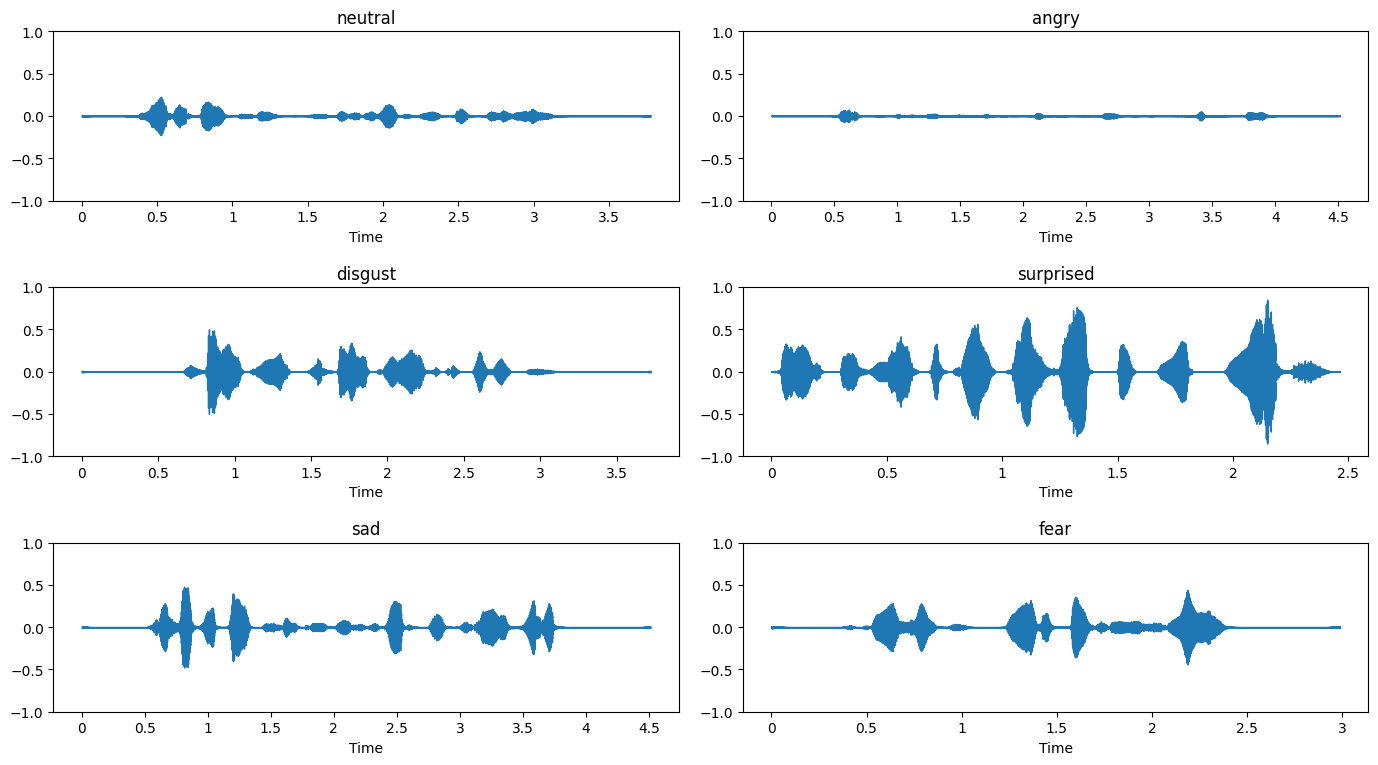

In [45]:
plt.figure(figsize=(14, 10))
emos,i = [],1
rwav = np.random.choice(os.listdir(dpath),500)
for wav in rwav:
  lab = labdict[re.match(r'^[a-zA-Z]+',wav.split('_')[1]).group()]
  if lab not in emos:
    emos.append(lab)
    audio_path = os.path.join(dpath,wav)
    y, sr = librosa.load(audio_path,sr=16000)
    ytrim, index = librosa.effects.trim(y,top_db=30)
    yclean = nr.reduce_noise(y=ytrim, sr=sr)
    plt.subplot(4,2,i)
    plt.title(lab)
    plt.ylim(-1,1)
    librosa.display.waveshow(yclean, sr=sr)
    i+=1
  if len(emos)==6:
    break
plt.tight_layout(pad=1.5)
plt.show()

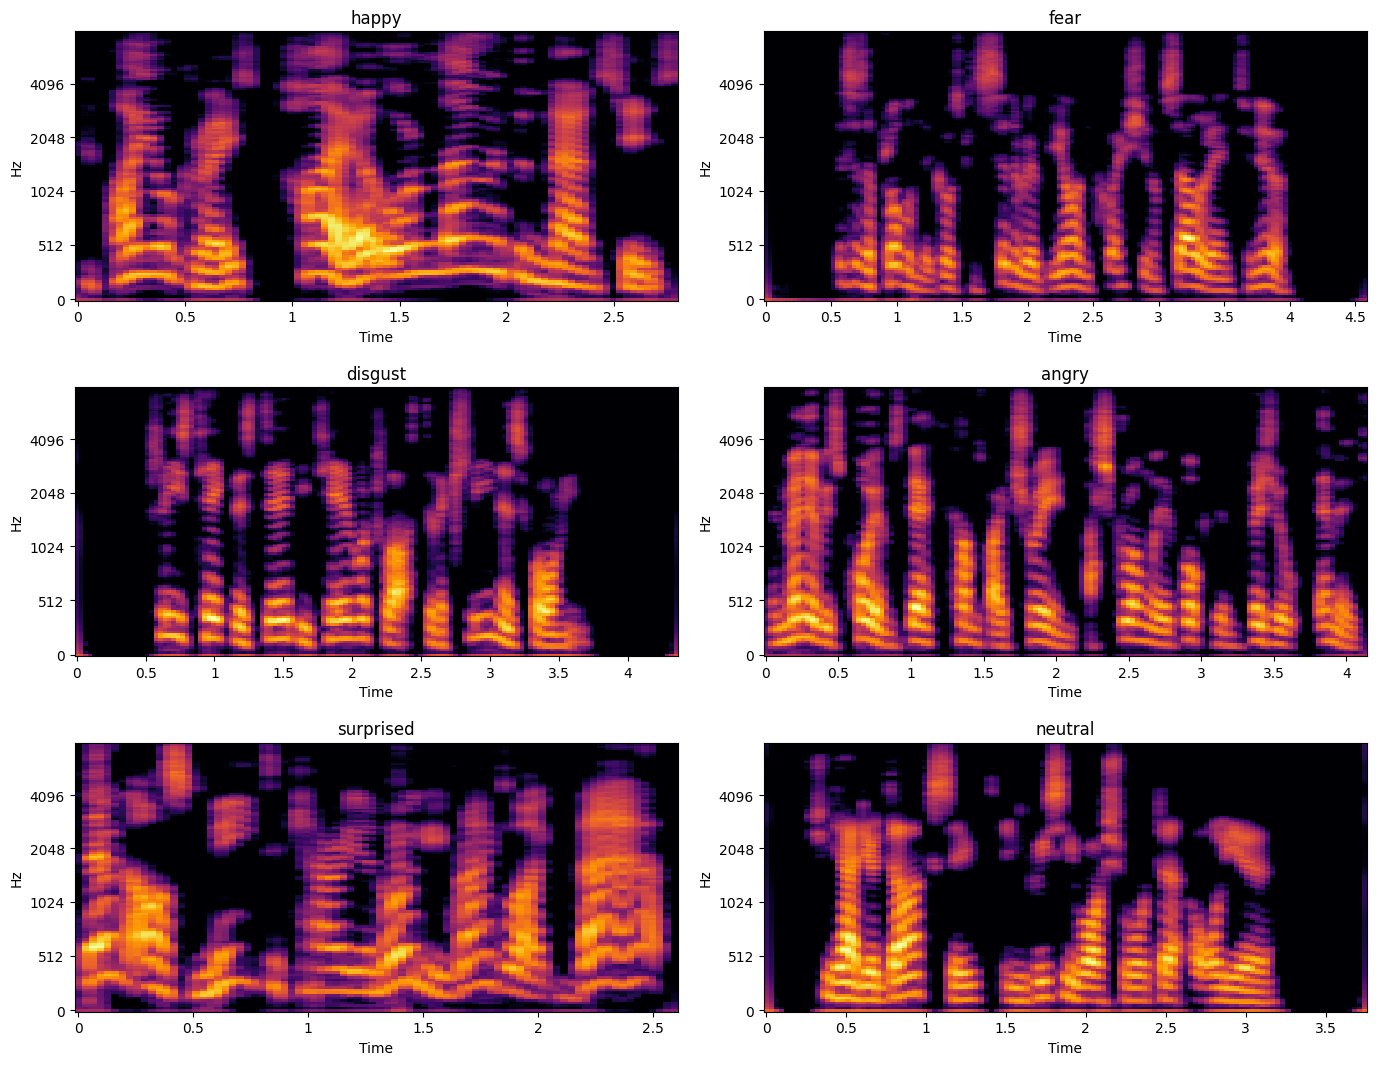

In [46]:
plt.figure(figsize=(14, 14))
emos,i = [],1
for wav in os.listdir(dpath):
  lab = labdict[re.match(r'^[a-zA-Z]+',wav.split('_')[1]).group()]
  if lab not in emos:
    emos.append(lab)
    audio_path = os.path.join(dpath,wav)
    y, sr = librosa.load(audio_path,sr=16000)
    ytrim, index = librosa.effects.trim(y,top_db=25)
    yclean = nr.reduce_noise(y=ytrim, sr=sr)
    plt.subplot(4,2,i)
    plt.title(lab)
    S = librosa.feature.melspectrogram(y=yclean, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr,cmap='inferno')
    i+=1
  if len(emos)==6:
    break
plt.tight_layout(pad=1.5)
plt.show()

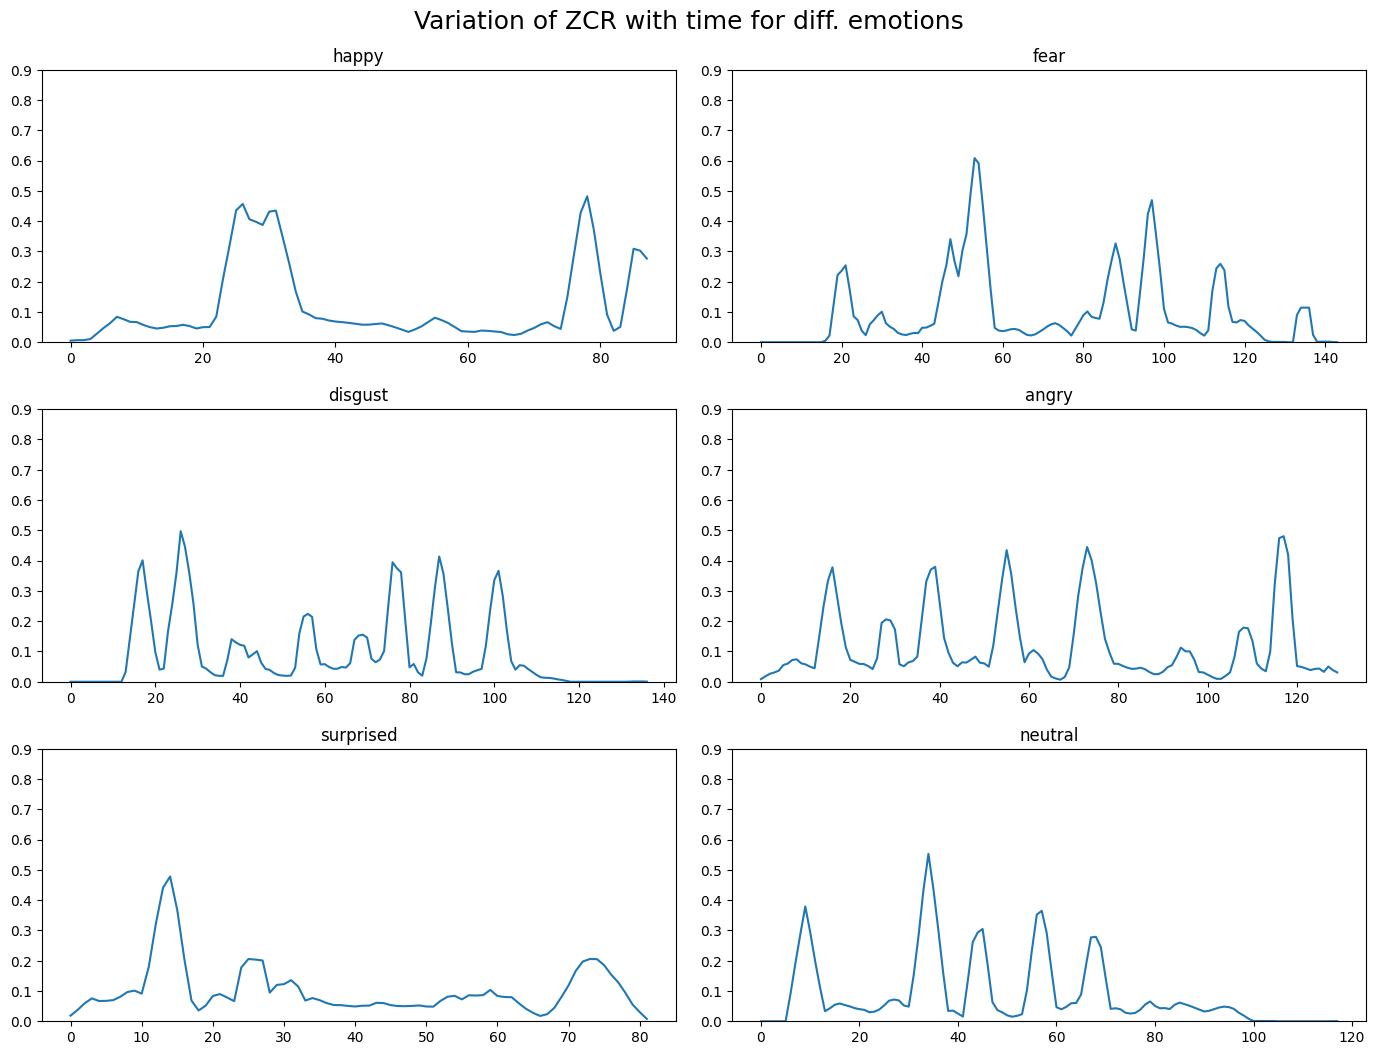

In [47]:
plt.figure(figsize=(14, 14))
emos,i = [],1
for wav in os.listdir(dpath):
  lab = labdict[re.match(r'^[a-zA-Z]+',wav.split('_')[1]).group()]
  if lab not in emos:
    emos.append(lab)
    audio_path = os.path.join(dpath,wav)
    y, sr = librosa.load(audio_path,sr=16000)
    ytrim, index = librosa.effects.trim(y,top_db=25)
    yclean = nr.reduce_noise(y=ytrim, sr=sr)
    plt.subplot(4,2,i)
    plt.title(lab)
    zcr = librosa.feature.zero_crossing_rate(yclean)
    plt.ylim(0,0.9)
    plt.plot(zcr[0])
    i+=1
  if len(emos)==6:
    break
plt.suptitle("Variation of ZCR with time for diff. emotions",fontsize=18)
plt.tight_layout(pad=1.5)
plt.show()

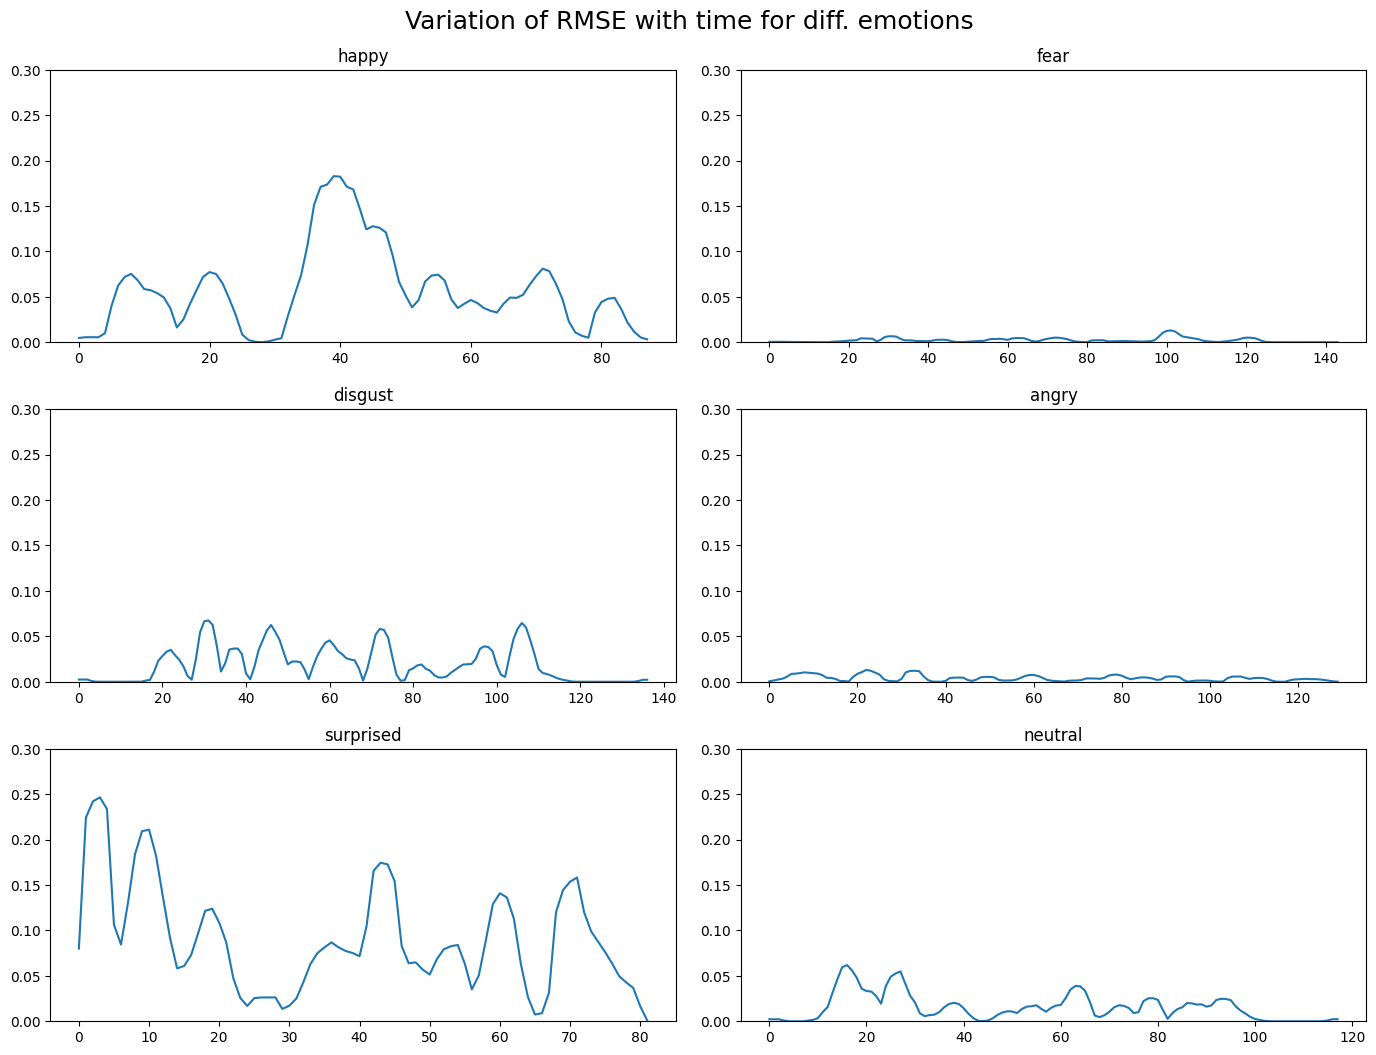

In [49]:
plt.figure(figsize=(14, 14))
emos,i = [],1
for wav in os.listdir(dpath):
  lab = labdict[re.match(r'^[a-zA-Z]+',wav.split('_')[1]).group()]
  if lab not in emos:
    emos.append(lab)
    audio_path = os.path.join(dpath,wav)
    y, sr = librosa.load(audio_path,sr=16000)
    ytrim, index = librosa.effects.trim(y,top_db=25)
    yclean = nr.reduce_noise(y=ytrim, sr=sr)
    plt.subplot(4,2,i)
    plt.title(lab)
    rmse = librosa.feature.rms(y=yclean)
    plt.ylim(0,0.3)
    plt.plot(rmse[0])
    i+=1
  if len(emos)==6:
    break
plt.suptitle("Variation of RMSE with time for diff. emotions",fontsize=18)
plt.tight_layout(pad=1.5)
plt.show()

In [50]:
audio_path = os.path.join(dpath,os.listdir(dpath)[0])
y, sr = librosa.load(audio_path,sr=16000)
ytrim, index = librosa.effects.trim(y,top_db=25)
yclean = nr.reduce_noise(y=ytrim, sr=sr)
dur = librosa.get_duration(y=yclean,sr=sr)
print("Duration:", dur)

mfcc = librosa.feature.mfcc(y=yclean, sr=sr, n_mfcc=13)
print("MFCC:", mfcc.shape)

mfcc2 = librosa.feature.mfcc(y=yclean, sr=sr, n_mfcc=20)
print("MFCC:", mfcc2.shape)

mfsp=librosa.feature.melspectrogram(y=yclean, sr=sr)
print("MFSP:", mfsp.shape)

zcr = librosa.feature.zero_crossing_rate(yclean)
print("Zero Crossing Rate:", zcr.shape)

rms = librosa.feature.rms(y=yclean)
print("RMS:", rms.shape)

chroma_stft = librosa.feature.chroma_stft(y=yclean, sr=sr)
print("Chroma STFT:", chroma_stft.shape)

spectral_contrast = librosa.feature.spectral_contrast(y=yclean, sr=sr)
print("Spectral Contrast:", spectral_contrast.shape)

tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(yclean), sr=sr)
print("Tonnetz:", tonnetz.shape)

Duration: 2.784
MFCC: (13, 88)
MFCC: (20, 88)
MFSP: (128, 88)
Zero Crossing Rate: (1, 88)
RMS: (1, 88)
Chroma STFT: (12, 88)
Spectral Contrast: (7, 88)
Tonnetz: (6, 88)


In [52]:
from scipy.stats import skew, kurtosis
def compute_statistics(feature, name):
    stats = {}
    stats[f'{name}_mean'] = np.mean(feature)
    stats[f'{name}_std'] = np.std(feature)
    stats[f'{name}_median'] = np.median(feature)
    stats[f'{name}_min'] = np.min(feature)
    stats[f'{name}_max'] = np.max(feature)
    stats[f'{name}_range'] = np.max(feature) - np.min(feature)
    stats[f'{name}_skewness'] = skew(feature)
    stats[f'{name}_kurtosis'] = kurtosis(feature)
    stats[f'{name}_25_%tile'] = np.percentile(feature, 25)
    stats[f'{name}_75_%tile'] = np.percentile(feature, 75)
    return stats
def extract_features(audio, sr):
    features = {}
    audio, _ = librosa.effects.trim(audio,top_db=30)
    audio = nr.reduce_noise(y=audio, sr=sr)
    if np.sum(np.isnan(audio))>0:
        return 0
    mfs=librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128,fmax=8000).mean(axis=1)
    for i, value in enumerate(mfs):
        features[f'mfs{i+1}'] = value

    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20).mean(axis=1)
    for i, value in enumerate(mfcc):
        features[f'mfcc{i+1}'] = value

    zcr = librosa.feature.zero_crossing_rate(audio)
    stats = compute_statistics(zcr[0], 'zcr')
    features.update(stats)

    rms = librosa.feature.rms(y=audio)
    stats = compute_statistics(rms[0], 'rms')
    features.update(stats)

    chroma = librosa.feature.chroma_stft(y=audio, sr=sr).mean(axis=1)
    for i, value in enumerate(chroma):
        features[f'chroma{i+1}'] = value

    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr).mean(axis=1)
    for i, value in enumerate(spectral_contrast):
        features[f'spectral_contrast{i+1}'] = value

    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr).mean(axis=1)
    for i, value in enumerate(tonnetz):
        features[f'tonnetz{i+1}'] = value
    return features

In [54]:
import warnings,tqdm
warnings.filterwarnings('ignore')
feats = []
for wav in tqdm.tqdm(os.listdir(dpath)):
    audio_path = os.path.join(dpath,wav)
    y, sr = librosa.load(audio_path,sr=16000)
    feat = extract_features(audio=y,sr=sr)
    if feat==0:
        plt.plot(y)
        continue
    label = labdict[re.match(r'^[a-zA-Z]+',wav.split('_')[1]).group()]
    feat['label'] = label
    feats.append(feat)
df = pd.DataFrame(feats)
df

100%|██████████| 480/480 [03:16<00:00,  2.44it/s]


,mfs1,mfs2,mfs3,mfs4,mfs5,mfs6,mfs7,mfs8,mfs9,mfs10,...,spectral_contrast5,spectral_contrast6,spectral_contrast7,tonnetz1,tonnetz2,tonnetz3,tonnetz4,tonnetz5,tonnetz6,label
0,0.006932,2.018238e-04,0.000390,0.004392,0.321868,1.425110,2.393212,2.180004,1.355399,2.012417,...,26.817978,33.021611,42.482408,0.028010,0.074103,-0.048504,0.106304,-0.005313,0.019461,happy
1,0.000169,2.368343e-06,0.000007,0.000572,0.002217,0.004972,0.002399,0.000405,0.001389,0.004709,...,31.136085,34.815784,34.712987,0.001137,0.018603,-0.017697,-0.017636,-0.023213,-0.012466,fear
2,0.046033,5.709649e-04,0.000291,0.000882,0.227073,1.203902,0.944393,0.867572,2.874736,11.676226,...,24.824585,26.992854,40.164093,0.004914,0.009618,0.090235,-0.013747,-0.003173,-0.002549,happy
3,0.034313,1.896741e-04,0.000365,0.031994,0.172464,0.325360,0.484908,0.959894,0.470832,0.129042,...,32.717446,26.943593,41.370173,-0.015606,0.040470,-0.066034,0.053448,-0.007722,0.005309,disgust
4,0.000046,5.458622e-07,0.000009,0.000485,0.002530,0.010937,0.006693,0.004649,0.001688,0.004445,...,32.732405,35.408699,40.693856,0.021587,0.016193,-0.037539,-0.027475,-0.008955,-0.009197,angry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,0.053584,7.912489e-03,0.002653,0.001528,0.003008,0.098680,0.178251,0.179696,0.302085,1.156448,...,26.511468,33.684706,49.075466,-0.036014,0.019621,0.090877,0.020097,-0.004844,0.029651,surprised
476,0.048705,4.863610e-04,0.000530,0.030410,0.262262,0.333501,0.104570,0.183309,0.080297,0.279697,...,31.889981,34.701645,35.966292,0.000188,0.011470,0.028298,-0.006866,0.008892,-0.000318,neutral
477,0.051488,2.979618e-04,0.001006,0.034412,0.161001,1.127082,1.531539,0.743240,0.139173,0.068072,...,29.436362,38.009093,39.506760,-0.018763,0.023321,-0.052676,-0.004813,0.006936,0.014999,neutral
478,0.000067,6.880851e-07,0.000017,0.000350,0.004254,0.010528,0.005164,0.001770,0.000708,0.005183,...,28.909253,37.818782,41.476071,0.005942,0.010603,-0.038569,0.029518,-0.001594,0.020933,angry


In [55]:
df['label'].value_counts()

label
neutral      120
fear          60
happy         60
disgust       60
angry         60
surprised     60
sad           60
Name: count, dtype: int64

In [56]:
df.to_csv('/kaggle/working/SAVEE_MFCC_etc_features_trim_NR.csv',index=False)

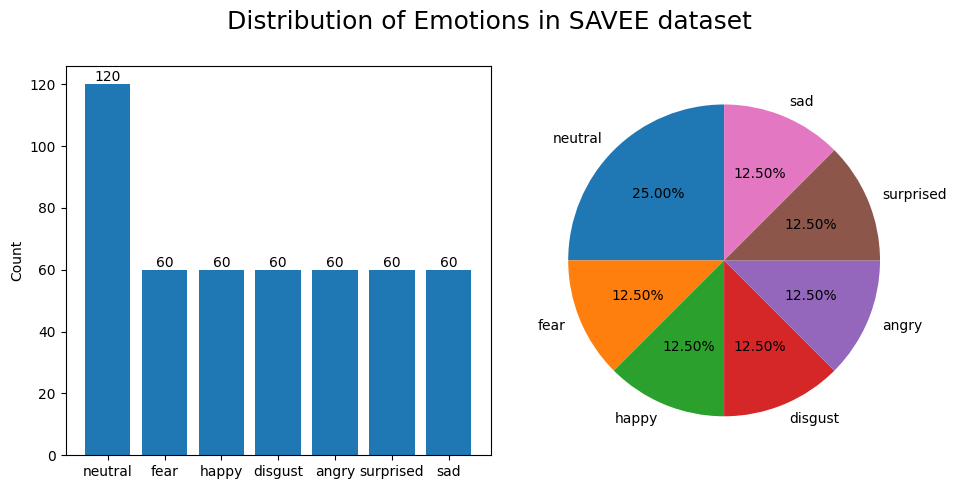

In [5]:
df = pd.read_csv('/kaggle/input/savee-mfcc-etc-features-trim-nr/SAVEE_MFCC_etc_features_trim_NR.csv')
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
bars = plt.bar(df['label'].value_counts().index, df['label'].value_counts().values)
plt.ylabel("Count")
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),bar.get_height(), ha='center', va='bottom')
plt.subplot(1, 2, 2)
df['label'].value_counts().plot(kind='pie',autopct='%1.2f%%',startangle=90)
plt.ylabel('')
plt.suptitle('Distribution of Emotions in SAVEE dataset', fontsize=18)
plt.tight_layout(pad=1.5)
plt.show()

In [61]:
xmfs = df[[c for c in df.columns if c.startswith("mfs")]]
xmfcc = df[[c for c in df.columns if c.startswith("mfcc")]]
xzcr = df[[c for c in df.columns if c.startswith("zcr")]]
xrmse = df[[c for c in df.columns if c.startswith("rms")]]
xchr = df[[c for c in df.columns if c.startswith("chroma")]]
xspc = df[[c for c in df.columns if c.startswith("spectral_contrast")]]
xton = df[[c for c in df.columns if c.startswith("tonnetz")]]
xall = df.drop('label',axis=1)
y = df['label']

In [62]:
def preprocess_split_train_test(df,model,name,apply_smote=False,rs=536,printres=True,returnModelFiles=False,apply_LDA=True,hppms=None):
  x = df.drop(['label'], axis=1)
  y = df['label']
  trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=rs,stratify=y)
  if apply_LDA:
    lda = LinearDiscriminantAnalysis()
    trainX = lda.fit_transform(trainX, trainY)
    testX = lda.transform(testX)
  le = LabelEncoder()
  y2 = le.fit_transform(y)
  if name=='XGBoost':
    trainY, testY = le.transform(trainY), le.transform(testY)
  if apply_smote:
    smote = SMOTE(random_state=42)
    trainX, trainY = smote.fit_resample(trainX, trainY)
  scaler = StandardScaler()
  trainX = scaler.fit_transform(trainX)
  testX = scaler.transform(testX)
  try:
      model.fit(trainX, trainY)
  except TypeError:
      return 0
  predictions = model.predict(testX)
  acc = accuracy_score(testY, predictions)
  if printres:
    plot_confusion_matrix(testY, predictions,le.classes_)
    print(f"\n{name} Accuracy: {acc*100:.3f}%")
    print(classification_report(testY, predictions))
  if returnModelFiles:
    return model,scaler,acc
  if hppms:
    return acc,hppms
  return acc

In [7]:
def plot_confusion_matrix(y_true, y_pred,labels):
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.show()

In [32]:
maxacc = 0
for i in range(1000):
    lr_model = LogisticRegression(C=0.3,class_weight='balanced')
    acc_lr = preprocess_split_train_test(df,lr_model,'Logistic Regression',rs=i,apply_LDA=False,printres=False)
    if acc_lr>maxacc:
        maxacc = acc_lr
        print(f"New highest acc = {maxacc*100:.3f}% at rs={i}")

New highest acc = 65.625% at rs=0
New highest acc = 67.708% at rs=9
New highest acc = 70.833% at rs=11
New highest acc = 75.000% at rs=92
New highest acc = 77.083% at rs=386


In [53]:
def getRandparams(mname):
    if mname == 'SVM':
        model_params = {
            'C': 10**np.random.uniform(np.log10(0.01), np.log10(10)),
            'kernel': np.random.choice(['linear', 'poly', 'rbf', 'sigmoid']),
            'gamma': 10**np.random.uniform(np.log10(0.00005), np.log10(0.0003)),
            'coef0': 10**np.random.uniform(0, np.log10(0.1)),
            'class_weight': np.random.choice(['balanced', None]),
            'decision_function_shape': np.random.choice(['ovo', 'ovr']),
            'random_state': np.random.randint(0, 1000),
        }
    elif mname == 'XGBoost':
        model_params = {
            'learning_rate': np.random.uniform(0.01, 0.5),
            'n_estimators': np.random.randint(50, 200),
            'max_depth': np.random.randint(3, 20),
            'min_child_weight': np.random.randint(1, 10),
            'gamma': np.random.uniform(0, 1),
            'subsample': np.random.uniform(0.3, 1),
            'colsample_bytree': np.random.uniform(0.5, 1),
            'reg_alpha': np.random.uniform(0, 1),
            'reg_lambda': np.random.uniform(0, 1),
            'scale_pos_weight': np.random.uniform(1, 15),
            'random_state': np.random.randint(0, 1000),
        }
    elif mname == 'LogisticRegression':
        model_params = {
            'C': 10**np.random.uniform(np.log10(0.001), np.log10(10)),
            'solver': np.random.choice(['newton-cg', 'lbfgs', 'sag', 'saga']),
            'class_weight': np.random.choice(['balanced', None]),
            'penalty': np.random.choice(['l1', 'l2', 'elasticnet', None]),
            'random_state': np.random.randint(0, 1000),
        }
        if model_params['solver'] in ['lbfgs','sag','newton-cg']:
            model_params['penalty'] = np.random.choice(['l2', None])
        if model_params['penalty']=='elasticnet':
            model_params['solver'] = 'saga'
    elif mname == 'RandomForest':
        model_params = {
            'n_estimators': np.random.randint(50, 700),
            'max_depth': np.random.randint(3, 50),
            'min_samples_split': np.random.randint(2, 20),
            'min_samples_leaf': np.random.randint(1, 10),
            'max_features': np.random.choice(['sqrt', 'log2', None]),
            'bootstrap': np.random.choice([True, False]),
            'class_weight': np.random.choice(['balanced', 'balanced_subsample', None]),
            'random_state': np.random.randint(0, 1000),
        }
    elif mname == 'KNN':
        model_params = {
            'n_neighbors': np.random.randint(3, 40),
            'weights': np.random.choice(['uniform', 'distance']),
            'algorithm': np.random.choice(['auto', 'ball_tree', 'kd_tree', 'brute']),
            'leaf_size': np.random.randint(20, 50),
            'p': np.random.choice([1, 2]),  # Minkowski metric (p=1 for Manhattan, p=2 for Euclidean)
        }
    elif mname == 'DecisionTree':
        model_params = {
            'criterion': np.random.choice(['gini', 'entropy', 'log_loss']),
            'splitter': np.random.choice(['best', 'random']),
            'max_depth': np.random.randint(3, 50),
            'min_samples_split': np.random.randint(2, 20),
            'min_samples_leaf': np.random.randint(1, 10),
            'max_features': np.random.choice([None, 'sqrt', 'log2']),
            'random_state': np.random.randint(0, 1000),
        }
    else:
        raise ValueError(f"Unsupported model name: {mname}")
    
    return model_params


In [66]:
def tune_ML_hppms(mname,model,iters=20,rs=None):
    hpr = []
    max_acc = 0
    best_model_params,best_prep_params,phist = dict(),dict(),dict()
    st0 = time.time()
    all_params = dict()
    for k in range(iters):
        st = time.time()
        model_params = getRandparams(mname)
        prep_params = {'rs':np.random.randint(0, 1000),
                       'apply_smote':np.random.choice([True,False]),
                        'apply_LDA':np.random.choice([True,False])}
        if rs:
            prep_params['rs'] = rs
        all_params = {**model_params, **prep_params}
        fparams = frozenset(all_params.items())
        #update model params
        model.set_params(**model_params)
        print(f"Iter No. - {k}")
        print(f"Model Params = {model_params}")
        print(f"Preprocessing Params = {prep_params}")
        acc = preprocess_split_train_test(df,model,mname,**prep_params,printres=False)
        en = time.time()
        tm = en-st
        tm0 = en-st0
        print(f"Time taken = {int(tm/60)} min {int(tm%60)} sec")
        ipd.clear_output(wait=True)
        print(f"Total Time taken = {int(tm0/60)} min {int(tm0%60)} sec")
        phist[fparams] = acc
        if acc>max_acc:
            max_acc = acc
            best_model_params = model_params
            best_prep_params = prep_params
            best_iter = k
        print(f"\nCurrent Accuracy = {acc*100:.2f}%")
        print(f"Best Accuracy = {max_acc*100:.2f}% at iter={best_iter}")
        print(f"Best Model Params Found so far = {best_model_params}\n")
        print(f"Best Preprocessing Params Found so far = {best_prep_params}\n")
    print("Hyperparameter Tuning Done!")
    model.set_params(**best_model_params)
    acc = preprocess_split_train_test(df,model,mname,**best_prep_params)
    return max_acc,best_model_params,best_prep_params

Total Time taken = 6 min 19 sec

Current Accuracy = 57.29%
Best Accuracy = 76.04% at iter=136
Best Model Params Found so far = {'learning_rate': 0.4411979502465016, 'n_estimators': 145, 'max_depth': 10, 'min_child_weight': 7, 'gamma': 0.5653690877370876, 'subsample': 0.7834966073931331, 'colsample_bytree': 0.8773456658667937, 'reg_alpha': 0.4990720942228718, 'reg_lambda': 0.6077168871118659, 'scale_pos_weight': 6.624547006745997, 'random_state': 687}

Best Preprocessing Params Found so far = {'rs': 912, 'apply_smote': True, 'apply_LDA': False}

Hyperparameter Tuning Done!


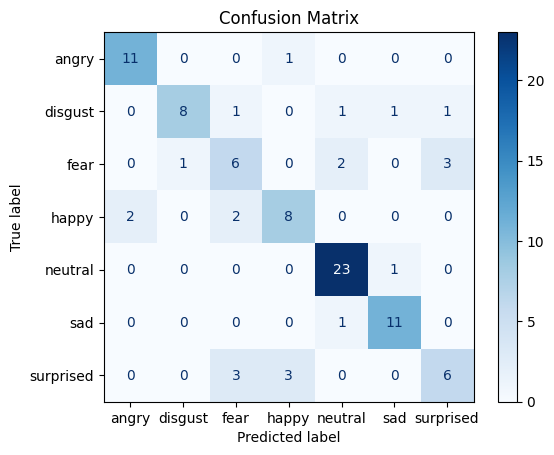


XGBoost Accuracy: 76.042%
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.89      0.67      0.76        12
           2       0.50      0.50      0.50        12
           3       0.67      0.67      0.67        12
           4       0.85      0.96      0.90        24
           5       0.85      0.92      0.88        12
           6       0.60      0.50      0.55        12

    accuracy                           0.76        96
   macro avg       0.74      0.73      0.73        96
weighted avg       0.76      0.76      0.75        96



ValueError: too many values to unpack (expected 2)

In [46]:
xgb_model = XGBClassifier(device='cuda')
max_acc,best_params = tune_ML_hppms('XGBoost',xgb_model,iters=500)

In [80]:
xgb_model = XGBClassifier(device='cuda')
max_acc,best_params = tune_ML_hppms('XGBoost',xgb_model,iters=2000)

Total Time taken = 22 min 56 sec

Current Accuracy = 60.42%
Best Accuracy = 81.25% at iter=1091
Best Params Found so far = {'learning_rate': 0.14218482437232138, 'n_estimators': 116, 'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.14772943843521535, 'subsample': 0.4353657208413746, 'colsample_bytree': 0.5817989513121927, 'reg_alpha': 0.47046905115543314, 'reg_lambda': 0.8022574911732642, 'scale_pos_weight': 8.496184590591906, 'random_state': 121, 'rs': 26, 'apply_smote': False, 'apply_LDA': False}

Hyperparameter Tuning Done!


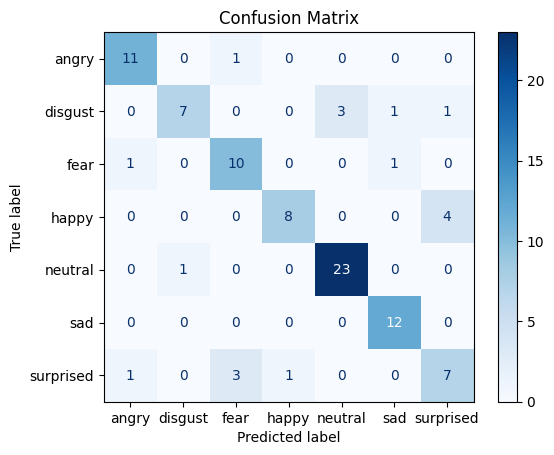


XGBoost Accuracy: 81.250%
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.88      0.58      0.70        12
           2       0.71      0.83      0.77        12
           3       0.89      0.67      0.76        12
           4       0.88      0.96      0.92        24
           5       0.86      1.00      0.92        12
           6       0.58      0.58      0.58        12

    accuracy                           0.81        96
   macro avg       0.81      0.79      0.79        96
weighted avg       0.82      0.81      0.81        96



In [81]:
mpm = {'learning_rate': 0.14218482437232138, 'n_estimators': 116, 'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.14772943843521535, 'subsample': 0.4353657208413746, 'colsample_bytree': 0.5817989513121927, 'reg_alpha': 0.47046905115543314, 'reg_lambda': 0.8022574911732642, 'scale_pos_weight': 8.496184590591906, 'random_state': 121}
ppm = {'rs': 26, 'apply_smote': False, 'apply_LDA': False}
xgb_model = XGBClassifier(device='cuda',**mpm)
acc_xgb = preprocess_split_train_test(df,xgb_model,'XGBoost',**ppm)

In [83]:
rf_model = RandomForestClassifier()
max_acc,best_params = tune_ML_hppms('RandomForest',rf_model,iters=50)

Total Time taken = 3 min 21 sec

Current Accuracy = 45.83%
Best Accuracy = 82.29% at iter=23
Best Params Found so far = {'n_estimators': 551, 'max_depth': 41, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced', 'random_state': 133, 'rs': 621, 'apply_smote': True, 'apply_LDA': False}

Hyperparameter Tuning Done!


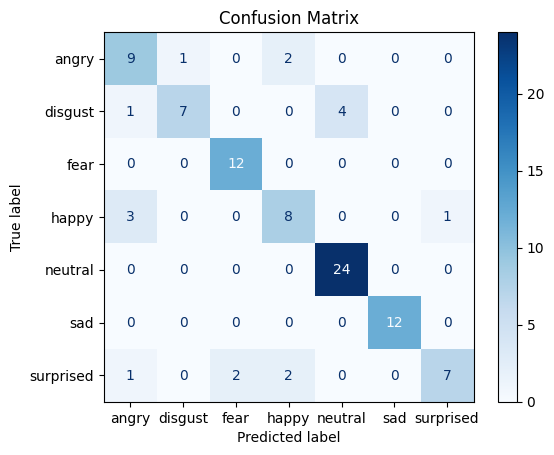


RandomForest Accuracy: 82.292%
              precision    recall  f1-score   support

       angry       0.64      0.75      0.69        12
     disgust       0.88      0.58      0.70        12
        fear       0.86      1.00      0.92        12
       happy       0.67      0.67      0.67        12
     neutral       0.86      1.00      0.92        24
         sad       1.00      1.00      1.00        12
   surprised       0.88      0.58      0.70        12

    accuracy                           0.82        96
   macro avg       0.82      0.80      0.80        96
weighted avg       0.83      0.82      0.82        96



In [90]:
rf_model = RandomForestClassifier(**{'n_estimators': 551, 'max_depth': 41, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced', 'random_state': 133})
acc_rf = preprocess_split_train_test(df,rf_model,'RandomForest',**{'rs': 621, 'apply_smote': True, 'apply_LDA': False})

Total Time taken = 6 min 18 sec

Current Accuracy = 77.08%
Best Accuracy = 82.29% at iter=39
Best Model Params Found so far = {'n_estimators': 510, 'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced_subsample', 'random_state': 491}

Best Preprocessing Params Found so far = {'rs': 621, 'apply_smote': False, 'apply_LDA': False}

Hyperparameter Tuning Done!


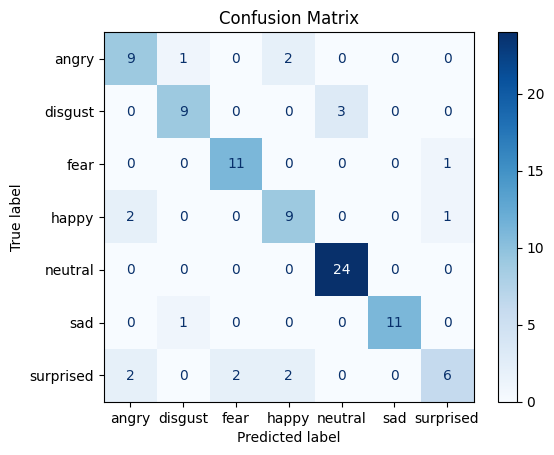


RandomForest Accuracy: 82.292%
              precision    recall  f1-score   support

       angry       0.69      0.75      0.72        12
     disgust       0.82      0.75      0.78        12
        fear       0.85      0.92      0.88        12
       happy       0.69      0.75      0.72        12
     neutral       0.89      1.00      0.94        24
         sad       1.00      0.92      0.96        12
   surprised       0.75      0.50      0.60        12

    accuracy                           0.82        96
   macro avg       0.81      0.80      0.80        96
weighted avg       0.82      0.82      0.82        96



In [80]:
rf_model = RandomForestClassifier()
max_acc,model_params,prep_params = tune_ML_hppms('RandomForest',rf_model,iters=150,rs=621)

Total Time taken = 1 min 12 sec

Current Accuracy = 41.67%
Best Accuracy = 69.79% at iter=513
Best Model Params Found so far = {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 27, 'p': 1}

Best Preprocessing Params Found so far = {'rs': 420, 'apply_smote': True, 'apply_LDA': False}

Hyperparameter Tuning Done!


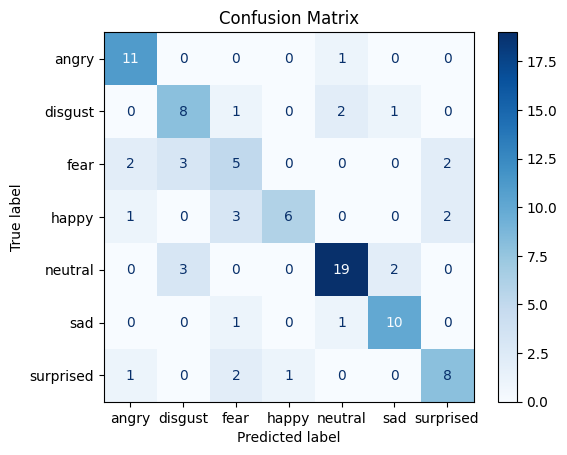


KNN Accuracy: 69.792%
              precision    recall  f1-score   support

       angry       0.73      0.92      0.81        12
     disgust       0.57      0.67      0.62        12
        fear       0.42      0.42      0.42        12
       happy       0.86      0.50      0.63        12
     neutral       0.83      0.79      0.81        24
         sad       0.77      0.83      0.80        12
   surprised       0.67      0.67      0.67        12

    accuracy                           0.70        96
   macro avg       0.69      0.68      0.68        96
weighted avg       0.71      0.70      0.70        96



In [13]:
knn_model = KNeighborsClassifier()
max_acc,best_model_params,best_prep_params = tune_ML_hppms('KNN',knn_model,iters=1000)

Total Time taken = 1 min 14 sec

Current Accuracy = 46.88%
Best Accuracy = 70.83% at iter=10
Best Model Params Found so far = {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'brute', 'leaf_size': 20, 'p': 1}

Best Preprocessing Params Found so far = {'rs': 420, 'apply_smote': True, 'apply_LDA': False}

Hyperparameter Tuning Done!


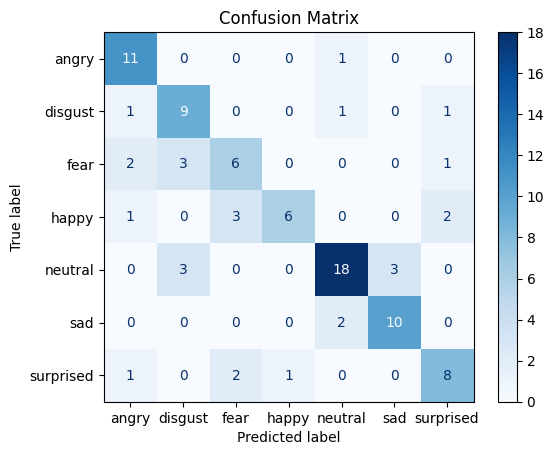


KNN Accuracy: 70.833%
              precision    recall  f1-score   support

       angry       0.69      0.92      0.79        12
     disgust       0.60      0.75      0.67        12
        fear       0.55      0.50      0.52        12
       happy       0.86      0.50      0.63        12
     neutral       0.82      0.75      0.78        24
         sad       0.77      0.83      0.80        12
   surprised       0.67      0.67      0.67        12

    accuracy                           0.71        96
   macro avg       0.71      0.70      0.69        96
weighted avg       0.72      0.71      0.70        96



In [74]:
knn_model = KNeighborsClassifier()
max_acc,best_model_params,best_prep_params = tune_ML_hppms('KNN',knn_model,iters=1000,rs=420)

Total Time taken = 1 min 13 sec

Current Accuracy = 45.83%
Best Accuracy = 70.83% at iter=118
Best Model Params Found so far = {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 32, 'p': 1}

Best Preprocessing Params Found so far = {'rs': 420, 'apply_smote': True, 'apply_LDA': False}

Hyperparameter Tuning Done!


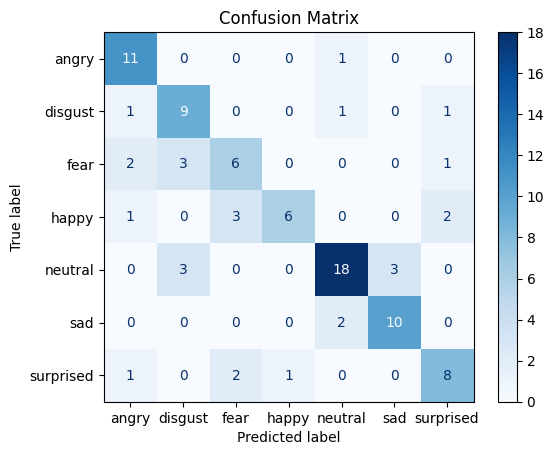


KNN Accuracy: 70.833%
              precision    recall  f1-score   support

       angry       0.69      0.92      0.79        12
     disgust       0.60      0.75      0.67        12
        fear       0.55      0.50      0.52        12
       happy       0.86      0.50      0.63        12
     neutral       0.82      0.75      0.78        24
         sad       0.77      0.83      0.80        12
   surprised       0.67      0.67      0.67        12

    accuracy                           0.71        96
   macro avg       0.71      0.70      0.69        96
weighted avg       0.72      0.71      0.70        96



In [75]:
knn_model = KNeighborsClassifier()
max_acc,best_model_params,best_prep_params = tune_ML_hppms('KNN',knn_model,iters=1000,rs=420)

Total Time taken = 2 min 9 sec

Current Accuracy = 31.25%
Best Accuracy = 65.62% at iter=396
Best Model Params Found so far = {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 11, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': None, 'random_state': 621}

Best Preprocessing Params Found so far = {'rs': 832, 'apply_smote': False, 'apply_LDA': False}

Hyperparameter Tuning Done!


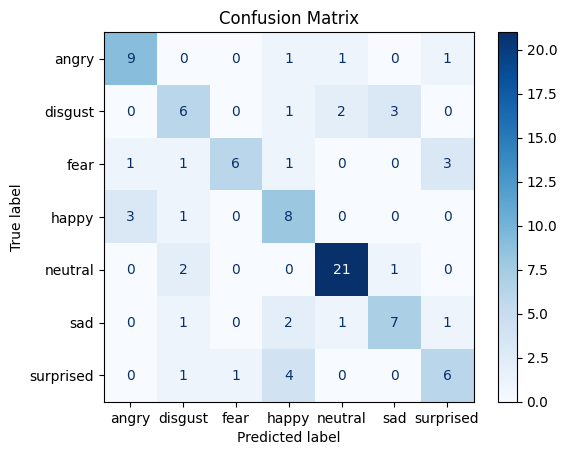


DecisionTree Accuracy: 65.625%
              precision    recall  f1-score   support

       angry       0.69      0.75      0.72        12
     disgust       0.50      0.50      0.50        12
        fear       0.86      0.50      0.63        12
       happy       0.47      0.67      0.55        12
     neutral       0.84      0.88      0.86        24
         sad       0.64      0.58      0.61        12
   surprised       0.55      0.50      0.52        12

    accuracy                           0.66        96
   macro avg       0.65      0.62      0.63        96
weighted avg       0.67      0.66      0.66        96



In [27]:
dt_model = DecisionTreeClassifier()
max_acc,best_model_params,best_prep_params = tune_ML_hppms('DecisionTree',dt_model,iters=2000)

Total Time taken = 1 min 4 sec

Current Accuracy = 44.79%
Best Accuracy = 65.62% at iter=453
Best Model Params Found so far = {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': None, 'random_state': 237}

Best Preprocessing Params Found so far = {'rs': 832, 'apply_smote': False, 'apply_LDA': False}

Hyperparameter Tuning Done!


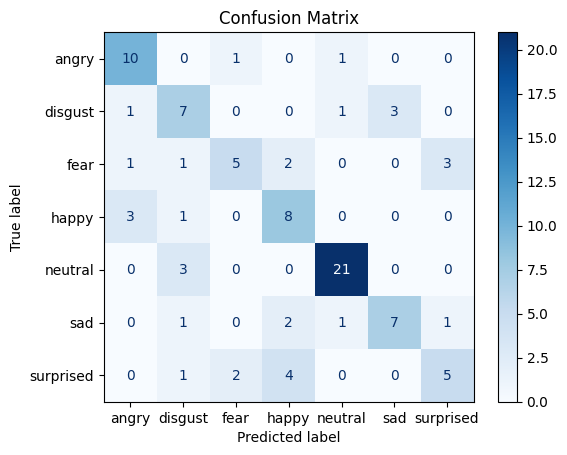


DecisionTree Accuracy: 65.625%
              precision    recall  f1-score   support

       angry       0.67      0.83      0.74        12
     disgust       0.50      0.58      0.54        12
        fear       0.62      0.42      0.50        12
       happy       0.50      0.67      0.57        12
     neutral       0.88      0.88      0.88        24
         sad       0.70      0.58      0.64        12
   surprised       0.56      0.42      0.48        12

    accuracy                           0.66        96
   macro avg       0.63      0.62      0.62        96
weighted avg       0.66      0.66      0.65        96



In [77]:
dt_model = DecisionTreeClassifier()
max_acc,best_model_params,best_prep_params = tune_ML_hppms('DecisionTree',dt_model,iters=1000,rs=832)

Total Time taken = 2 min 48 sec

Current Accuracy = 48.96%
Best Accuracy = 72.92% at iter=1845
Best Model Params Found so far = {'C': 0.019664571617790297, 'kernel': 'linear', 'gamma': 8.046600839325573e-05, 'coef0': 0.13273525049504373, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'random_state': 917}

Best Preprocessing Params Found so far = {'rs': 572, 'apply_smote': True, 'apply_LDA': False}

Hyperparameter Tuning Done!


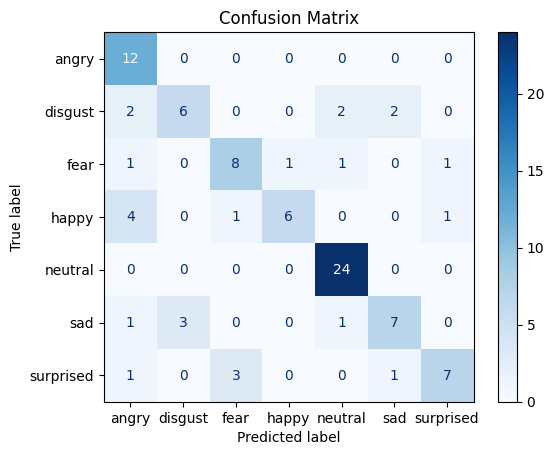


SVM Accuracy: 72.917%
              precision    recall  f1-score   support

       angry       0.57      1.00      0.73        12
     disgust       0.67      0.50      0.57        12
        fear       0.67      0.67      0.67        12
       happy       0.86      0.50      0.63        12
     neutral       0.86      1.00      0.92        24
         sad       0.70      0.58      0.64        12
   surprised       0.78      0.58      0.67        12

    accuracy                           0.73        96
   macro avg       0.73      0.69      0.69        96
weighted avg       0.74      0.73      0.72        96



In [58]:
svm_model = SVC()
max_acc,best_model_params,best_prep_params = tune_ML_hppms('SVM',svm_model,iters=2000)

Total Time taken = 1 min 22 sec

Current Accuracy = 36.46%
Best Accuracy = 78.12% at iter=124
Best Model Params Found so far = {'C': 0.044354323389919986, 'kernel': 'linear', 'gamma': 0.00015502431636962846, 'coef0': 0.1427597074232259, 'class_weight': None, 'decision_function_shape': 'ovr', 'random_state': 926}

Best Preprocessing Params Found so far = {'rs': 386, 'apply_smote': False, 'apply_LDA': False}

Hyperparameter Tuning Done!


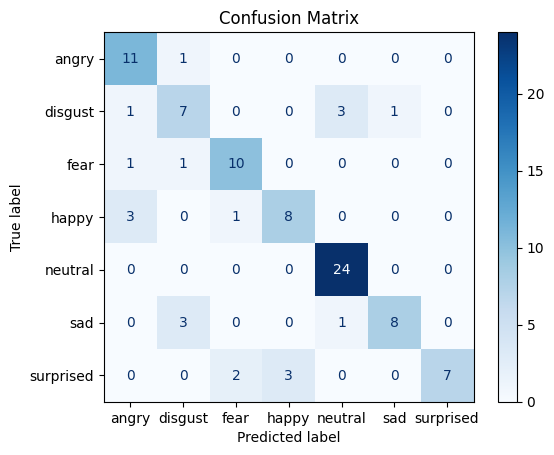


SVM Accuracy: 78.125%
              precision    recall  f1-score   support

       angry       0.69      0.92      0.79        12
     disgust       0.58      0.58      0.58        12
        fear       0.77      0.83      0.80        12
       happy       0.73      0.67      0.70        12
     neutral       0.86      1.00      0.92        24
         sad       0.89      0.67      0.76        12
   surprised       1.00      0.58      0.74        12

    accuracy                           0.78        96
   macro avg       0.79      0.75      0.76        96
weighted avg       0.80      0.78      0.78        96



In [69]:
svm_model = SVC()
max_acc,best_model_params,best_prep_params = tune_ML_hppms('SVM',svm_model,iters=1000,rs=386)

Total Time taken = 5 min 59 sec

Current Accuracy = 55.21%
Best Accuracy = 70.83% at iter=324
Best Model Params Found so far = {'C': 0.5902922645051735, 'solver': 'lbfgs', 'class_weight': None, 'penalty': 'l2', 'random_state': 966}

Best Preprocessing Params Found so far = {'rs': 297, 'apply_smote': True, 'apply_LDA': False}

Hyperparameter Tuning Done!


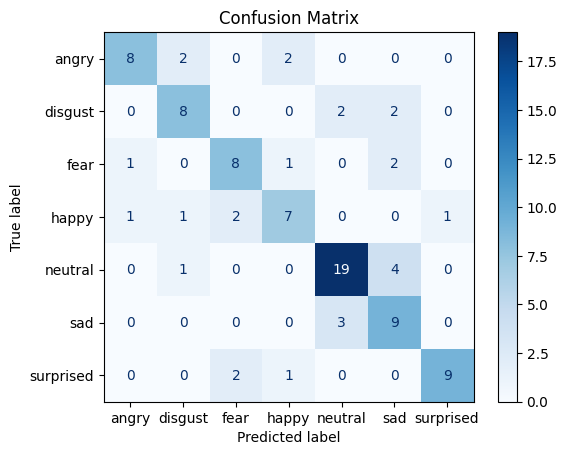


LogisticRegression Accuracy: 70.833%
              precision    recall  f1-score   support

       angry       0.80      0.67      0.73        12
     disgust       0.67      0.67      0.67        12
        fear       0.67      0.67      0.67        12
       happy       0.64      0.58      0.61        12
     neutral       0.79      0.79      0.79        24
         sad       0.53      0.75      0.62        12
   surprised       0.90      0.75      0.82        12

    accuracy                           0.71        96
   macro avg       0.71      0.70      0.70        96
weighted avg       0.72      0.71      0.71        96



ValueError: too many values to unpack (expected 2)

In [64]:
lr_model = LogisticRegression(max_iter=1000)
max_acc,best_model_params,best_prep_params = tune_ML_hppms('LogisticRegression',lr_model,iters=500)

Total Time taken = 5 min 46 sec

Current Accuracy = 52.08%
Best Accuracy = 80.21% at iter=94
Best Model Params Found so far = {'C': 3.951244281997974, 'solver': 'saga', 'class_weight': None, 'penalty': 'l2', 'random_state': 197}

Best Preprocessing Params Found so far = {'rs': 386, 'apply_smote': False, 'apply_LDA': False}

Hyperparameter Tuning Done!


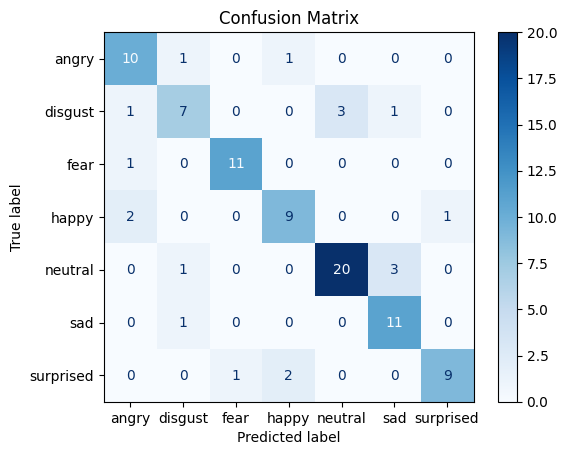


LogisticRegression Accuracy: 80.208%
              precision    recall  f1-score   support

       angry       0.71      0.83      0.77        12
     disgust       0.70      0.58      0.64        12
        fear       0.92      0.92      0.92        12
       happy       0.75      0.75      0.75        12
     neutral       0.87      0.83      0.85        24
         sad       0.73      0.92      0.81        12
   surprised       0.90      0.75      0.82        12

    accuracy                           0.80        96
   macro avg       0.80      0.80      0.79        96
weighted avg       0.81      0.80      0.80        96



In [68]:
lr_model = LogisticRegression(max_iter=1000)
max_acc,best_model_params,best_prep_params = tune_ML_hppms('LogisticRegression',lr_model,iters=500,rs=386)

Total Time taken = 6 min 42 sec

Current Accuracy = 75.00%
Best Accuracy = 80.21% at iter=100
Best Model Params Found so far = {'C': 0.08640129516877831, 'solver': 'saga', 'class_weight': None, 'penalty': 'l2', 'random_state': 50}

Best Preprocessing Params Found so far = {'rs': 386, 'apply_smote': False, 'apply_LDA': False}

Hyperparameter Tuning Done!


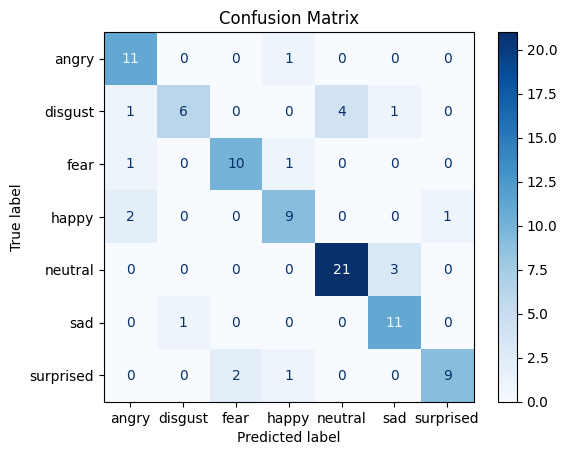


LogisticRegression Accuracy: 80.208%
              precision    recall  f1-score   support

       angry       0.73      0.92      0.81        12
     disgust       0.86      0.50      0.63        12
        fear       0.83      0.83      0.83        12
       happy       0.75      0.75      0.75        12
     neutral       0.84      0.88      0.86        24
         sad       0.73      0.92      0.81        12
   surprised       0.90      0.75      0.82        12

    accuracy                           0.80        96
   macro avg       0.81      0.79      0.79        96
weighted avg       0.81      0.80      0.80        96



In [78]:
lr_model = LogisticRegression(max_iter=1000)
max_acc,best_model_params,best_prep_params = tune_ML_hppms('LogisticRegression',lr_model,iters=500,rs=386)

In [64]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization,Input
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adadelta,Adagrad,Adamax,Nadam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE

In [65]:
def split_preprocess(df,apply_smote=False,rs=536,returnscalerle=False):
  x = df.drop(['label'], axis=1)
  y = df['label']
  trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=rs,stratify=y)
  scaler = StandardScaler()
  trainX = scaler.fit_transform(trainX)
  testX = scaler.transform(testX)
  if apply_smote:
    smote = SMOTE(random_state=42)
    trainX, trainY = smote.fit_resample(trainX, trainY)
  le = LabelEncoder()
  trainY_enc = to_categorical(le.fit_transform(trainY))
  testY_enc = to_categorical(le.transform(testY))
  if returnscalerle:
    return trainX, testX, trainY, testY, trainY_enc,testY_enc, scaler,le
  return trainX, testX, trainY, testY,trainY_enc,testY_enc

In [66]:
trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le = split_preprocess(df,rs=710,returnscalerle=True)
model = Sequential()
model.add(Input((trainX.shape[1],)))
model.add(Dense(20, activation='relu',kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(40, activation='relu',kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(80, activation='relu',kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(np.unique(trainY)), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 20)             │         3,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 80)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           567 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,127 (35.65 KB)

 Trainable params: 8,847 (34.56 KB)

 Non-trainable params: 280 (1.09 KB)

In [67]:
import shutil
mpath = '/kaggle/working/ann_model_savee_mfcc.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.00001),
             tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_accuracy', save_best_only=True,verbose=1)]
history = model.fit(trainX, trainY_enc, epochs=500, batch_size=32, validation_data=(testX, testY_enc),callbacks=callbacks)
_, accuracy = model.evaluate(testX, testY_enc)
print('\nAccuracy: %.2f' % (accuracy*100))
predictions = model.predict(testX)
predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))
print(classification_report(testY, predicted_labels))
new_mpath = f"/kaggle/working/ann_model_savee_mfcc_val_acc_{accuracy*100:.2f}.keras"
shutil.move(mpath, new_mpath)

Epoch 1/500


I0000 00:00:1732528513.028585     150 service.cc:145] XLA service 0x791b28017990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732528513.028640     150 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732528513.028644     150 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1:23 8s/step - accuracy: 0.1250 - loss: 3.5941

I0000 00:00:1732528518.319543     150 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_accuracy improved from -inf to 0.22917, saving model to /kaggle/working/ann_model_savee_mfcc.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.1491 - loss: 3.7509 - val_accuracy: 0.2292 - val_loss: 3.0530 - learning_rate: 0.0010
Epoch 2/500
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1562 - loss: 3.5814
Epoch 2: val_accuracy improved from 0.22917 to 0.27083, saving model to /kaggle/working/ann_model_savee_mfcc.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2283 - loss: 3.4545 - val_accuracy: 0.2708 - val_loss: 3.0003 - learning_rate: 0.0010
Epoch 3/500
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3125 - loss: 3.1878
Epoch 3: val_accuracy improved from 0.27083 to 0.30208, saving model to /kaggle/working/ann_model_savee_mfcc.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3134 - loss: 3.0414 - val_accuracy: 0.3021 - val_loss: 2.9539 - learning_rate: 0.0010
Epoch 4/500
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1

'/kaggle/working/ann_model_savee_mfcc_val_acc_57.29.keras'

In [68]:
from tensorflow.keras.regularizers import l1,l2,l1_l2
    
def getRandomHPPMS():
    params = {}
    params['rs_split'] = np.random.randint(0,1000)
    #params['rs_split'] = 6
    params['num_HL'] = np.random.randint(2,4+1)
    for i in range(1,params['num_HL']+1):
        params[f'units_{i}'] = np.random.choice(range(64,512+2,2))
        params[f'KR_{i}'] = np.random.choice(['l1','l2','l1l2','none'])
        params[f'BN_{i}'] = np.random.choice([True,False])
        #params[f'dropout_rate_{i}'] = np.random.choice(np.round(np.arange(0,0.5+0.1,0.1),1))
        params[f'dropout_rate_{i}'] = np.round(np.random.uniform(0,0.5),4)
    params['learning_rate'] = np.random.uniform(0.0001,0.005)
    optims = ['Adam','SGD','RMSprop','Adadelta','Adagrad','Adamax','Nadam']
    params['optimizer'] = np.random.choice(optims)
    params['batch_size'] = np.random.choice(range(32,132,4))
    params['adpLR'] = np.random.choice([True,False])
    params['apply_smote'] = np.random.choice([True,False])
    return params

def buildntrainmodel(params,feats,max_epochs=500):
    trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le = split_preprocess(feats,rs=params['rs_split'],apply_smote=params['apply_smote'],returnscalerle=True)
    model = Sequential()
    model.add(Input((trainX.shape[1],)))
    for i in range(1,params['num_HL']+1):
        kern = {'l1':l1(),'l2':l2(),'l1l2':l1_l2(),'none':None}
        model.add(Dense(units=params[f'units_{i}'],activation='relu',kernel_regularizer=kern[params[f'KR_{i}']]))
        if params[f'BN_{i}']:
            model.add(BatchNormalization())
        if params[f'dropout_rate_{i}']>0:
            model.add(Dropout(params[f'dropout_rate_{i}']))
    model.add(Dense(len(np.unique(trainY)), activation='softmax'))
    optimizer_dict = {'Adam': Adam(learning_rate=params['learning_rate']),
                      'SGD': SGD(learning_rate=params['learning_rate']),
                      'RMSprop': RMSprop(learning_rate=params['learning_rate']),
                      'Adadelta': Adadelta(learning_rate=params['learning_rate']),
                      'Adagrad': Adagrad(learning_rate=params['learning_rate']),
                      'Adamax': Adamax(learning_rate=params['learning_rate']),
                      'Nadam': Nadam(learning_rate=params['learning_rate'])}
    
    model.compile(optimizer=optimizer_dict[params['optimizer']], loss='categorical_crossentropy', metrics=['accuracy'])
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)]
    if params['adpLR']:
        callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.00001))
    histann = model.fit(trainX, trainY_enc, epochs=max_epochs, batch_size=params['batch_size'],validation_data=(testX, testY_enc),callbacks=callbacks)
    _, accuracy = model.evaluate(testX, testY_enc)
    splits = (trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le)
    return accuracy,params,model,splits,histann

In [70]:
import IPython.display as ipd
import time
def plot_history(hist,acc,id):
  plt.figure(figsize=(12, 6))
  plt.suptitle(f'Training & Validation Curves for Best ANN Model - Val_Acc={acc*100:.2f}% at Trial #{id}', fontsize=16)
  plt.subplot(1, 2, 1)
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')

  plt.subplot(1, 2, 2)
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='lower right')
  plt.tight_layout()
  plt.show()
    
def tune_hyperparams(ntrials,feats,max_epochs=500):
    max_acc = 0
    totm = 0
    phist = dict()
    histories = dict()
    for i in range(1,ntrials+1):
        st = time.time()
        print(f"\nRunning Trial #{i}\n")
        params = getRandomHPPMS()
        if i==1:
            best_params = params
        print(f"{'Current Value':<15}{'|Best Value So Far':<21}{'|Hyperparameter'}")
        print(f"{'-' * 15}|{'-' * 20}|{'-' * 15}")
        for param, value in params.items():
            best_value = best_params.get(param, 'N/A')
            if param=='learning_rate':
                best_value,value = round(best_value,3),round(value,3)
            print(f"{str(value):<15}|{str(best_value):<20}|{param}")
        print()
        acc,params,model,splits,histann = buildntrainmodel(params,feats,max_epochs=max_epochs)
        trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le = splits
        fparams = frozenset(params.items())
        phist[fparams] = acc
        histories[i] = histann
        if acc>max_acc:
            max_acc = acc
            best_params = params
            best_trial = i
            best_model = model
        ipd.clear_output(wait=True)
        en = time.time()
        tm = en-st
        totm+=tm
        ep = len(histann.history['accuracy'])
        tracc = max(histann.history['accuracy'])
        print(f"Trial {i} Complete [{int(tm/3600)}h {int(tm/60)}m {int(tm%60)}s] - Trained for {ep} epochs")
        print(f"train_accuracy = {tracc*100:.3f}%")
        print(f"val_accuracy = {acc*100:.3f}%")
        print(f"Overfitting Difference = {(tracc-acc)*100:.3f}%\n")
        print(f"Best val_accuracy So Far: {max_acc*100:.3f}% at Trial #{best_trial}")
        print(f"Total time elapsed: [{int(totm/3600)}h {int(totm/60)}m {int(totm%60)}s]")
    print(f"Best Hyperparameters: {best_params}")
    print("Best Model Summary:")
    print(best_model.summary())
    best_hist = histories[best_trial]
    plot_history(best_hist,max_acc,best_trial)
    trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le = split_preprocess(feats,rs=best_params['rs_split'],apply_smote=best_params['apply_smote'],returnscalerle=True)
    predictions = best_model.predict(testX)
    predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))
    cm = confusion_matrix(testY, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for Best ANN Model")
    plt.show()
    print(f"\nAccuracy = {accuracy_score(testY,predicted_labels)*100:.3f}%\n")
    print(classification_report(testY, predicted_labels))
    best_model.save(f"/kaggle/working/ann_model_savee_mfcc_val_acc_{max_acc*100:.2f}.keras")
    return max_acc, best_params, best_trial, best_model, phist,histories

Trial 20 Complete [0h 0m 7s] - Trained for 26 epochs
train_accuracy = 26.042%
val_accuracy = 26.042%
Overfitting Difference = 0.000%

Best val_accuracy So Far: 76.042% at Trial #9
Total time elapsed: [0h 4m 21s]
Best Hyperparameters: {'rs_split': 780, 'num_HL': 2, 'units_1': 298, 'KR_1': 'l1l2', 'BN_1': False, 'dropout_rate_1': 0.354, 'units_2': 400, 'KR_2': 'none', 'BN_2': False, 'dropout_rate_2': 0.0826, 'learning_rate': 0.003630390038037464, 'optimizer': 'Adamax', 'batch_size': 56, 'adpLR': True, 'apply_smote': False}
Best Model Summary:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_37 (Dense)                │ (None, 298)            │        57,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 298)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 400)            │       119,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 7)              │         2,807 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 540,659 (2.06 MB)

 Trainable params: 180,219 (703.98 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 360,440 (1.37 MB)

None


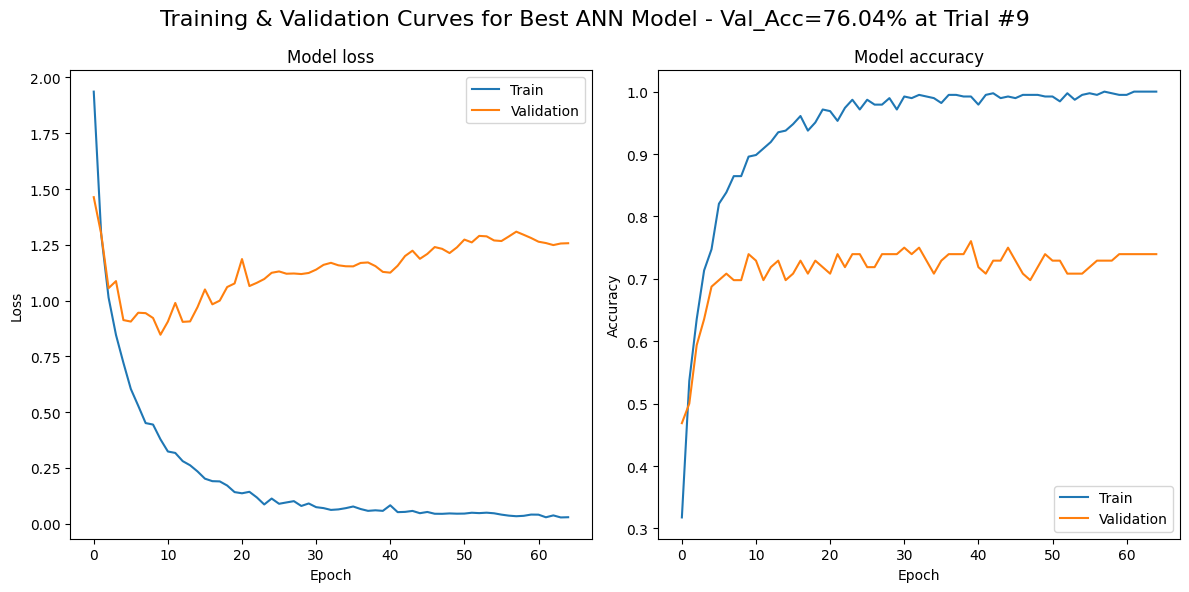

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


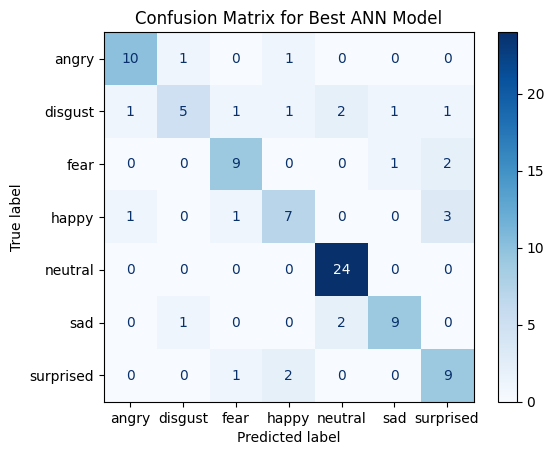


Accuracy = 76.042%

              precision    recall  f1-score   support

       angry       0.83      0.83      0.83        12
     disgust       0.71      0.42      0.53        12
        fear       0.75      0.75      0.75        12
       happy       0.64      0.58      0.61        12
     neutral       0.86      1.00      0.92        24
         sad       0.82      0.75      0.78        12
   surprised       0.60      0.75      0.67        12

    accuracy                           0.76        96
   macro avg       0.74      0.73      0.73        96
weighted avg       0.76      0.76      0.75        96



In [71]:
max_acc, best_params, best_trial, best_model, phist, histories = tune_hyperparams(ntrials=20,feats=df,max_epochs=500)

Trial 20 Complete [0h 0m 11s] - Trained for 69 epochs
train_accuracy = 45.833%
val_accuracy = 41.667%
Overfitting Difference = 4.167%

Best val_accuracy So Far: 79.167% at Trial #11
Total time elapsed: [0h 5m 21s]
Best Hyperparameters: {'rs_split': 572, 'num_HL': 3, 'units_1': 302, 'KR_1': 'none', 'BN_1': True, 'dropout_rate_1': 0.3595, 'units_2': 494, 'KR_2': 'none', 'BN_2': False, 'dropout_rate_2': 0.2941, 'units_3': 248, 'KR_3': 'l2', 'BN_3': True, 'dropout_rate_3': 0.4805, 'learning_rate': 0.00453597967854106, 'optimizer': 'Adam', 'batch_size': 72, 'adpLR': True, 'apply_smote': True}
Best Model Summary:


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_116 (Dense)               │ (None, 302)            │        58,588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 302)            │         1,208 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 302)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 494)            │       149,682 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 494)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 248)            │       122,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 248)            │           992 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 248)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 7)              │         1,743 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,002,721 (3.83 MB)

 Trainable params: 333,873 (1.27 MB)

 Non-trainable params: 1,100 (4.30 KB)

 Optimizer params: 667,748 (2.55 MB)

None


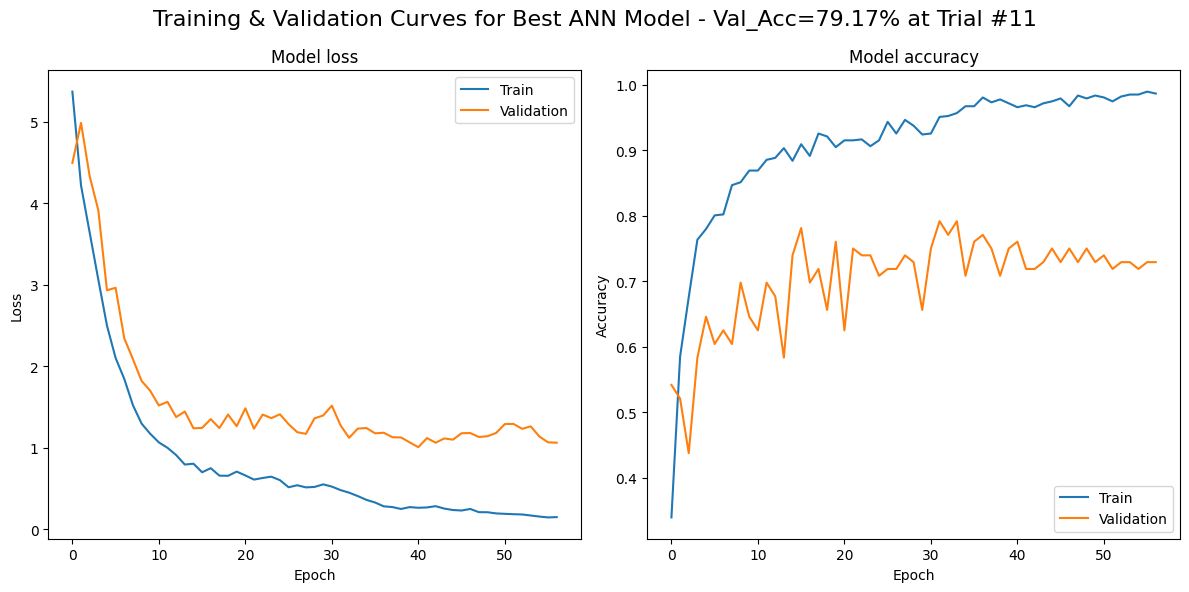

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


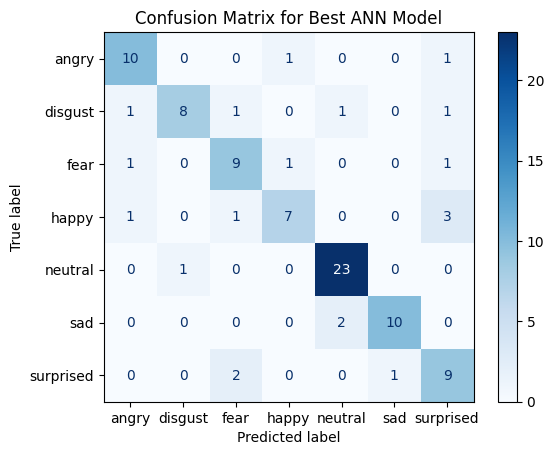


Accuracy = 79.167%

              precision    recall  f1-score   support

       angry       0.77      0.83      0.80        12
     disgust       0.89      0.67      0.76        12
        fear       0.69      0.75      0.72        12
       happy       0.78      0.58      0.67        12
     neutral       0.88      0.96      0.92        24
         sad       0.91      0.83      0.87        12
   surprised       0.60      0.75      0.67        12

    accuracy                           0.79        96
   macro avg       0.79      0.77      0.77        96
weighted avg       0.80      0.79      0.79        96



In [72]:
max_acc, best_params, best_trial, best_model, phist, histories = tune_hyperparams(ntrials=20,feats=df,max_epochs=500)

Trial 20 Complete [0h 0m 13s] - Trained for 33 epochs
train_accuracy = 99.405%
val_accuracy = 61.458%
Overfitting Difference = 37.946%

Best val_accuracy So Far: 78.125% at Trial #4
Total time elapsed: [0h 4m 46s]
Best Hyperparameters: {'rs_split': 572, 'num_HL': 2, 'units_1': 268, 'KR_1': 'none', 'BN_1': False, 'dropout_rate_1': 0.1527, 'units_2': 506, 'KR_2': 'l2', 'BN_2': True, 'dropout_rate_2': 0.1087, 'learning_rate': 0.001569919427838709, 'optimizer': 'RMSprop', 'batch_size': 60, 'adpLR': True, 'apply_smote': True}
Best Model Summary:


Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_326 (Dense)               │ (None, 268)            │        51,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_242 (Dropout)           │ (None, 268)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_327 (Dense)               │ (None, 506)            │       136,114 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_120         │ (None, 506)            │         2,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_243 (Dropout)           │ (None, 506)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_328 (Dense)               │ (None, 7)              │         3,549 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 386,348 (1.47 MB)

 Trainable params: 192,667 (752.61 KB)

 Non-trainable params: 1,012 (3.95 KB)

 Optimizer params: 192,669 (752.62 KB)

None


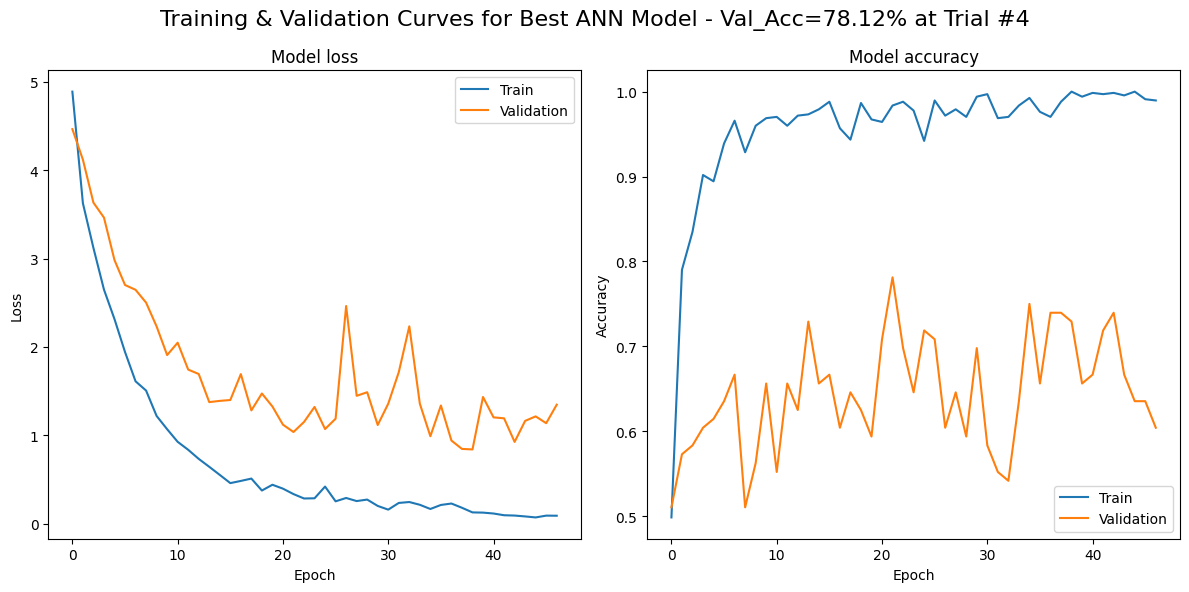

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


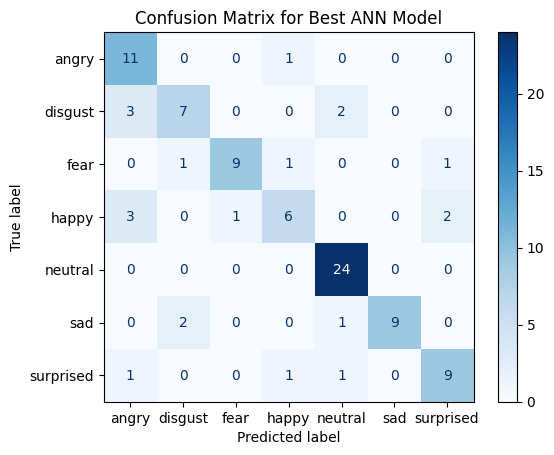


Accuracy = 78.125%

              precision    recall  f1-score   support

       angry       0.61      0.92      0.73        12
     disgust       0.70      0.58      0.64        12
        fear       0.90      0.75      0.82        12
       happy       0.67      0.50      0.57        12
     neutral       0.86      1.00      0.92        24
         sad       1.00      0.75      0.86        12
   surprised       0.75      0.75      0.75        12

    accuracy                           0.78        96
   macro avg       0.78      0.75      0.76        96
weighted avg       0.79      0.78      0.78        96



In [75]:
def getRandomHPPMS():
    params = {}
    #params['rs_split'] = np.random.randint(0,1000)
    params['rs_split'] = 572
    params['num_HL'] = np.random.randint(2,4+1)
    for i in range(1,params['num_HL']+1):
        params[f'units_{i}'] = np.random.choice(range(64,512+2,2))
        params[f'KR_{i}'] = np.random.choice(['l1','l2','l1l2','none'])
        params[f'BN_{i}'] = np.random.choice([True,False])
        #params[f'dropout_rate_{i}'] = np.random.choice(np.round(np.arange(0,0.5+0.1,0.1),1))
        params[f'dropout_rate_{i}'] = np.round(np.random.uniform(0,0.5),4)
    params['learning_rate'] = np.random.uniform(0.0001,0.005)
    optims = ['Adam','SGD','RMSprop','Adadelta','Adagrad','Adamax','Nadam']
    params['optimizer'] = np.random.choice(optims)
    params['batch_size'] = np.random.choice(range(32,132,4))
    params['adpLR'] = np.random.choice([True,False])
    params['apply_smote'] = np.random.choice([True,False])
    return params
max_acc, best_params, best_trial, best_model, phist, histories = tune_hyperparams(ntrials=20,feats=df,max_epochs=500)